[View in Colaboratory](https://colab.research.google.com/github/adrshm91/DrivFace/blob/master/DrivFace_NoAugumentation.ipynb)

In [0]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
temp_dir = 'data/temp'
orig_dir = 'data/images'
train_dir = 'data/train'
val_dir = 'data/val'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

In [0]:
def load_dataset():
  if not os.path.exists(orig_dir):
    
    # download the dataset
    
    os.makedirs(temp_dir)
    os.makedirs(orig_dir)
    print("Downloading dataset to "+ temp_dir)
    file = wget.download(url, out=temp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(temp_dir)
    pzf = PyZipFile(temp_dir+'/DrivFace/DrivImages.zip')
    pzf.extractall(temp_dir)
    print("Moving files to "+orig_dir)
    for file in os.listdir(temp_dir+'/DrivImages'):
      shutil.move(temp_dir+'/DrivImages/'+file,orig_dir+'/'+file)
    shutil.move(temp_dir+'/DrivFace/drivPoints.txt',orig_dir+'/drivPoints.txt')
    print("Deleting temporary directory "+ temp_dir)
    shutil.rmtree(temp_dir)

In [0]:
def split_dataset(orig_dir, train_dir, val_dir, split_ratio):
  
  if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    print("Creating train directories for each class")
    train_ff_dir = os.path.join(train_dir, 'ff')
    os.makedirs(train_ff_dir)
    train_ll_dir = os.path.join(train_dir, 'll')
    os.makedirs(train_ll_dir)
    train_lr_dir = os.path.join(train_dir, 'lr')
    os.makedirs(train_lr_dir)

    print("Creating val directories for each class")
    val_ff_dir = os.path.join(val_dir, 'ff')
    os.makedirs(val_ff_dir)
    val_ll_dir = os.path.join(val_dir, 'll')
    os.makedirs(val_ll_dir)
    val_lr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(val_lr_dir)

    files = pd.read_csv(orig_dir+'/drivPoints.txt')['fileName'].tolist()
    files_ff = [file for file in files if 'f' in file]
    files_ll = [file for file in files if 'll' in file]
    files_lr = [file for file in files if 'lr' in file]
    i = 0
    for fname in files_ff:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ff_dir, fname + '.jpg')
      dst_val = os.path.join(val_ff_dir, fname + '.jpg')
      i += 1
      if i < len(files_ff)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_ll:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ll_dir, fname + '.jpg')
      dst_val = os.path.join(val_ll_dir, fname + '.jpg')
      i += 1
      if i < len(files_ll)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_lr:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_lr_dir, fname + '.jpg') 
      dst_val = os.path.join(val_lr_dir, fname + '.jpg')
      i += 1
      if i < len(files_lr)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)

In [148]:
load_dataset()


Unzipping the files..
Moving files to data/images
Deleting temporary directory data/temp


In [149]:
split_dataset(orig_dir, train_dir, val_dir, split_ratio = 0.8)

Creating train directories for each class
Creating val directories for each class


In [153]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [158]:
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,                                             
        target_size=(64, 64),                                 
        batch_size=20,
    class_mode='categorical')                                   

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode='categorical')

Found 483 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


In [159]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3729 - acc: 0.9017 - val_loss: 0.4267 - val_acc: 0.8956
Epoch 2/30
100/100 [==============================] - 15s 152ms/step - loss: 0.2896 - acc: 0.9067 - val_loss: 0.4756 - val_acc: 0.8956
Epoch 3/30
100/100 [==============================] - 15s 151ms/step - loss: 0.2229 - acc: 0.9200 - val_loss: 0.7983 - val_acc: 0.5051
Epoch 4/30
100/100 [==============================] - 15s 153ms/step - loss: 0.1847 - acc: 0.9392 - val_loss: 0.9531 - val_acc: 0.4177
Epoch 5/30
100/100 [==============================] - 15s 153ms/step - loss: 0.1406 - acc: 0.9512 - val_loss: 0.9907 - val_acc: 0.5358
Epoch 6/30
100/100 [==============================] - 15s 152ms/step - loss: 0.1135 - acc: 0.9610 - val_loss: 1.0575 - val_acc: 0.5119
Epoch 7/30
100/100 [==============================] - 15s 152ms/step - loss: 0.0982 - acc: 0.9639 - val_loss: 1.3163 - val_acc: 0.3916
Epoch 8/30
100/100 [==============================] - 1

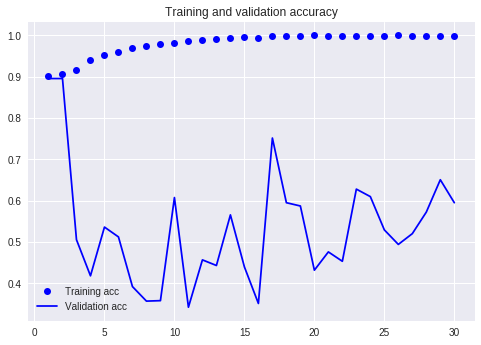

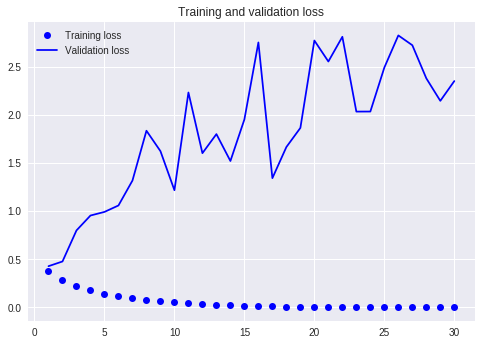

In [160]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()